# Initialize Colab Environment

Note: adapted from https://colab.research.google.com/drive/1V3TOkPcU8pfPdoxH_UTSPUcNAfAtH9rW#scrollTo=rQtGe_MH746N

API documentation: https://github.com/gsbDBI/ds-wgan

And adapted from Athey, Susan, Guido Imbens, Jonas Metzger, and Evan Munro. "Using Wasserstein Generative Adversial Networks for the Design of Monte Carlo Simulations." arXiv:1909.02210.

Data from Alan, Sule, et al. "Building Social Cohesion in Ethnically Mixed Schools: An Intervention on Perspective Taking." (2020).

https://www.povertyactionlab.org/sites/default/files/research-paper/working-paper_5838_Building-Cohesion-in-Schools_Turkey_Oct2020.pdf




First, we mount Google drive, where the data are stored

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


We import the wgan package from the paper:

In [ ]:
!pip3 uninstall wgan
!pip3 install git+https://github.com/gsbDBI/ds-wgan.git

  Cloning https://github.com/gsbDBI/ds-wgan.git to /tmp/pip-req-build-7x5_nnuo
  Running command git clone -q https://github.com/gsbDBI/ds-wgan.git /tmp/pip-req-build-7x5_nnuo
  Created wheel for wgan: filename=wgan-0.2-cp37-none-any.whl size=12055 sha256=e86269e3c4330c9fcae77ec990479ae8531898b5238706950cc52381b62da8f5
  Stored in directory: /tmp/pip-ephem-wheel-cache-u20a3asd/wheels/3a/11/00/ece0eed5e7b5b70a47e0042a54d2470e4fe140182eb66463f6
Successfully built wgan


### Load dependencies

First we load dependencies and our csv from the real data (note, this contains only the covariates and outcome variable "fdonation_perc" for simplicity)

In [ ]:
import pandas as pd 
import wgan 
import io 
import requests
from copy import copy
import numpy as np

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/fraction_donated.csv',index_col=0)

In [ ]:
real_list = []
for i in range(0,6577):
  real_list.append("real")
df2['source']=real_list

### Configuration 1

Like the original paper, we create a balanced dataset to train on (this should alter very little as the dataset is balanced, but just in case). We then choose our configuration. In this configuration, we condition only on treatment, and do not generate and class or school_level covariates

In [ ]:
df2_balanced = df2.sample(2*len(df2), weights=(1-df2.treatment.mean())*df2.treatment+df2.treatment.mean()*(1-df2.treatment), replace=True) # balanced df for training

# X | t
continuous_vars_0 = ["ageinm", "braven_sd", "beyes_sd", "bdonation_sd"]
continuous_lower_bounds_0 = {}
categorical_vars_0 = ["a2", "inter1", "male", "refugee","astudent"]
context_vars_0 = ["treatment"]

# Y | X, t
continuous_vars_1 = []
continuous_lower_bounds_1 = {}
categorical_vars_1 = ["fdonation_perc"]
context_vars_1 = ["ageinm", "braven_sd", "beyes_sd", "b_schoolsize","f_csize","b_schoolid", "a2", "inter1", "male", "refugee","astudent","treatment","bstrata","bdonation_sd"]

# Initialize objects
data_wrappers = [wgan.DataWrapper(df2_balanced, continuous_vars_0, categorical_vars_0, 
                                  context_vars_0, continuous_lower_bounds_0),
                 wgan.DataWrapper(df2_balanced, continuous_vars_1, categorical_vars_1, 
                                  context_vars_1, continuous_lower_bounds_1)]
specs = [wgan.Specifications(dw, batch_size=4096, max_epochs=1000, critic_lr=1e-3, generator_lr=1e-3,
                             print_every=100, device = "cuda") for dw in data_wrappers]
generators = [wgan.Generator(spec) for spec in specs]
critics = [wgan.Critic(spec) for spec in specs]

settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 15, 'critic_lr': 0.001, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 0.001, 'generator_d_noise': 14, 'generator_optimizer': 'optimizer', 'max_epochs': 1000, 'batch_size': 4096, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 100, 'device': 'cuda'}
settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 15, 'critic_lr': 0.001, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 0.001, 'generator_d_noise': 5, 'generator_optimizer': 'optimizer', 'max_epochs': 1000, 'batch_size': 4096, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 100, 'device': 'cuda'}


We generate 10 GANs that each generate 100 datasets. 

First we generate the covariates, then the outcome variable.

We also generate a counterfactual outcome variable so that we can find the "true" TE of Y(1) - Y(0)

Finally, we regenerate the treatment and randomize at the student level, then re-generate the outcome variable (as if we had randomized students)


In [ ]:
for i in range(0,10):
  x, context = data_wrappers[0].preprocess(df2_balanced)
  wgan.train(generators[0], critics[0], x, context, specs[0])
  # train Y | X, t
  x, context = data_wrappers[1].preprocess(df2_balanced)
  wgan.train(generators[1], critics[1], x, context, specs[1])
  for j in range(0,100):
    # simulate data with conditional WGANs
    df2_generated = data_wrappers[0].apply_generator(generators[0], df2)
    df2_generated = data_wrappers[1].apply_generator(generators[1], df2_generated)


    #add counterfactual outcomes
    df2_generated_cf = copy(df2_generated)
    df2_generated_cf["treatment"] = 1 - df2_generated_cf["treatment"] 
    df2_generated["fdonation_perc_cf"] = data_wrappers[1].apply_generator(generators[1], df2_generated_cf)['fdonation_perc']
    
    #randomize treatment and re-generate outcome
    df2_individual = copy(df2_generated)
    df2_individual['treatment'] = np.random.choice([1,0],len(df2_individual),p=[.5,.5])
    df2_individual = data_wrappers[1].apply_generator(generators[1], df2_individual)
    
    #save
    df2_generated.to_csv('/content/drive/MyDrive/GANs-simple/cohesion_simple_'+str(i)+'_'+str(j)+'.csv')
    df2_individual.to_csv('/content/drive/MyDrive/GANs-simple/cohesion_simple_individual_'+str(i)+'_'+str(j)+'.csv')


epoch 0 | step 5 | WD_test 0.71 | WD_train 0.58 | sec passed 0 |
epoch 100 | step 405 | WD_test 0.22 | WD_train 0.43 | sec passed 13 |
epoch 200 | step 805 | WD_test 0.44 | WD_train 0.5 | sec passed 13 |
epoch 300 | step 1205 | WD_test 0.1 | WD_train 0.4 | sec passed 13 |
epoch 400 | step 1605 | WD_test 0.91 | WD_train 0.5 | sec passed 13 |
epoch 500 | step 2005 | WD_test -0.06 | WD_train 0.28 | sec passed 13 |
epoch 600 | step 2405 | WD_test 0.29 | WD_train 0.39 | sec passed 13 |
epoch 700 | step 2805 | WD_test 0.48 | WD_train 0.43 | sec passed 13 |
epoch 800 | step 3205 | WD_test 0.28 | WD_train 0.4 | sec passed 13 |
epoch 900 | step 3605 | WD_test 0.35 | WD_train 0.35 | sec passed 13 |
epoch 0 | step 5 | WD_test 0.28 | WD_train 0.36 | sec passed 0 |
epoch 100 | step 405 | WD_test 0.18 | WD_train 0.38 | sec passed 13 |
epoch 200 | step 805 | WD_test 0.19 | WD_train 0.32 | sec passed 13 |
epoch 300 | step 1205 | WD_test 0.21 | WD_train 0.28 | sec passed 13 |
epoch 400 | step 1605 | WD

We can then compare means and correlations with the real data for the school randomized and individual randomized versions

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/fraction_donated.csv',index_col=0)
df_generated = pd.read_csv('/content/drive/MyDrive/GANs-simple/cohesion_simple_0_0.csv',index_col=0)

att: 0.05694558381186765
-------------comparison of means-------------
treatment            0               1        
source            fake    real    fake    real
fdonation_perc    0.36    0.34    0.41    0.39
ageinm          105.36  105.14  105.51  105.37
male              0.50    0.51    0.52    0.50
bstrata          27.81   27.81   27.25   27.25
refugee           0.20    0.18    0.15    0.15
astudent          0.02    0.04    0.04    0.04
braven_sd        -0.01   -0.02    0.01   -0.04
beyes_sd          0.11    0.03    0.10    0.02
b_schoolsize    521.38  521.38  534.64  534.64
f_csize          36.33   36.33   35.99   35.99
b_schoolid      157.51  157.51  152.19  152.19
a2                0.52    0.49    0.50    0.49
inter1            0.01    0.00    0.49    0.49
bdonation_sd      0.10   -0.05    0.03   -0.06
-------------comparison of stds-------------
treatment            0               1        
source            fake    real    fake    real
fdonation_perc    0.31    0.31    0.31

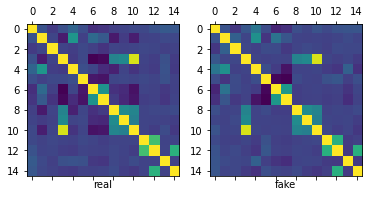

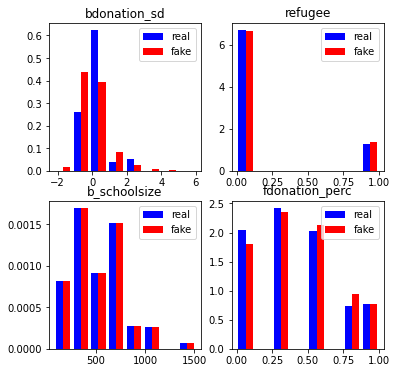

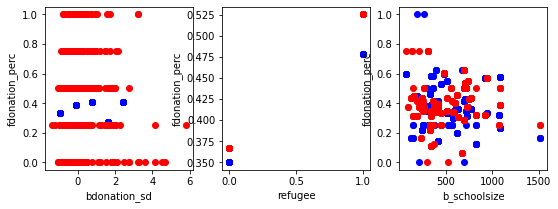

In [ ]:
print("att:", ((df_generated.fdonation_perc-df_generated.fdonation_perc_cf) * (2*df_generated.treatment - 1))[df_generated.treatment==1].mean())
wgan.compare_dfs(df, df_generated, 
                 scatterplot=dict(x=["bdonation_sd", "refugee", "b_schoolsize"], y=["fdonation_perc"], samples=400, smooth=0),
                 table_groupby=["treatment"],
                 histogram=dict(variables=["bdonation_sd", "refugee", "b_schoolsize","fdonation_perc"], nrow=2, ncol=2),
                 figsize=3)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/fraction_donated.csv',index_col=0)
df_generated = pd.read_csv('/content/drive/MyDrive/GANs-simple/cohesion_simple_individual_0_0.csv',index_col=0)

att: 0.027490886998784932
-------------comparison of means-------------
treatment            0               1        
source            fake    real    fake    real
fdonation_perc    0.36    0.34    0.41    0.39
ageinm          105.54  105.14  105.35  105.37
male              0.52    0.51    0.50    0.50
bstrata          27.61   27.81   27.38   27.25
refugee           0.17    0.18    0.17    0.15
astudent          0.03    0.04    0.03    0.04
braven_sd        -0.01   -0.02    0.02   -0.04
beyes_sd          0.10    0.03    0.11    0.02
b_schoolsize    532.37  521.38  525.14  534.64
f_csize          36.18   36.33   36.10   35.99
b_schoolid      155.15  157.51  153.94  152.19
a2                0.52    0.49    0.51    0.49
inter1            0.29    0.00    0.27    0.49
bdonation_sd      0.07   -0.05    0.05   -0.06
-------------comparison of stds-------------
treatment            0               1        
source            fake    real    fake    real
fdonation_perc    0.31    0.31    0.3

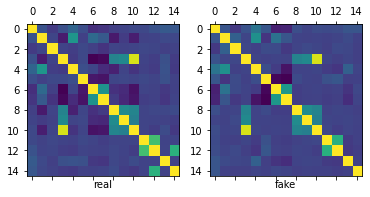

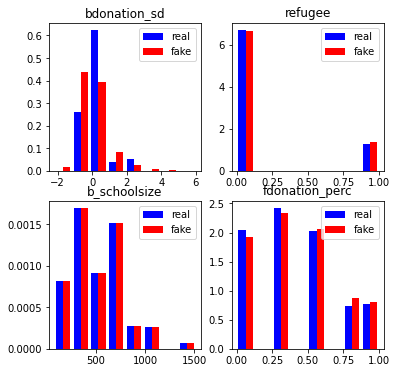

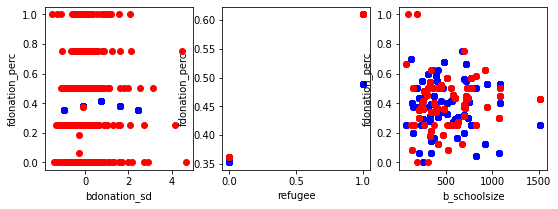

In [ ]:
print("att:", ((df_generated.fdonation_perc-df_generated.fdonation_perc_cf) * (2*df_generated.treatment - 1))[df_generated.treatment==1].mean())
wgan.compare_dfs(df, df_generated, 
                 scatterplot=dict(x=["bdonation_sd", "refugee", "b_schoolsize"], y=["fdonation_perc"], samples=400, smooth=0),
                 table_groupby=["treatment"],
                 histogram=dict(variables=["bdonation_sd", "refugee", "b_schoolsize","fdonation_perc"], nrow=2, ncol=2),
                 figsize=3)

### Configuration 2

In this configuration, we condition only on treatment, and generate all covariates

In [ ]:
df2_balanced = df2.sample(2*len(df2), weights=(1-df2.treatment.mean())*df2.treatment+df2.treatment.mean()*(1-df2.treatment), replace=True) # balanced df for training

# X | t
continuous_vars_0 = ["ageinm", "braven_sd", "beyes_sd", "bdonation_sd"]
continuous_lower_bounds_0 = {"b_schoolsize":0,"f_csize":0}
categorical_vars_0 = ["a2", "inter1", "male", "refugee","astudent", "b_schoolsize","f_csize","b_schoolid","bstrata"]
context_vars_0 = ["treatment"]

# Y | X, t
continuous_vars_1 = []
continuous_lower_bounds_1 = {}
categorical_vars_1 = ["fdonation_perc"]
context_vars_1 = ["ageinm", "braven_sd", "beyes_sd", "b_schoolsize","f_csize","b_schoolid", "a2", "inter1", "male", "refugee","astudent","treatment","bstrata","bdonation_sd"]

# Initialize objects
data_wrappers = [wgan.DataWrapper(df2_balanced, continuous_vars_0, categorical_vars_0, 
                                  context_vars_0, continuous_lower_bounds_0),
                 wgan.DataWrapper(df2_balanced, continuous_vars_1, categorical_vars_1, 
                                  context_vars_1, continuous_lower_bounds_1)]
specs = [wgan.Specifications(dw, batch_size=4096, max_epochs=1000, critic_lr=1e-3, generator_lr=1e-3,
                             print_every=100, device = "cuda") for dw in data_wrappers]
generators = [wgan.Generator(spec) for spec in specs]
critics = [wgan.Critic(spec) for spec in specs]

settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 15, 'critic_lr': 0.001, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 0.001, 'generator_d_noise': 206, 'generator_optimizer': 'optimizer', 'max_epochs': 1000, 'batch_size': 4096, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 100, 'device': 'cuda'}
settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 15, 'critic_lr': 0.001, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 0.001, 'generator_d_noise': 5, 'generator_optimizer': 'optimizer', 'max_epochs': 1000, 'batch_size': 4096, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 100, 'device': 'cuda'}


In [ ]:
for i in range(0,10):
  x, context = data_wrappers[0].preprocess(df2_balanced)
  wgan.train(generators[0], critics[0], x, context, specs[0])
  # train Y | X, t
  x, context = data_wrappers[1].preprocess(df2_balanced)
  wgan.train(generators[1], critics[1], x, context, specs[1])
  for j in range(0,100):
    # simulate data with conditional WGANs
    df2_generated = data_wrappers[0].apply_generator(generators[0], df2)
    df2_generated = data_wrappers[1].apply_generator(generators[1], df2_generated)


    #add counterfactual outcomes
    df2_generated_cf = copy(df2_generated)
    df2_generated_cf["treatment"] = 1 - df2_generated_cf["treatment"] 
    df2_generated["fdonation_perc_cf"] = data_wrappers[1].apply_generator(generators[1], df2_generated_cf)['fdonation_perc']
    
    #randomize treatment and re-generate outcome
    df2_individual = copy(df2_generated)
    df2_individual['treatment'] = np.random.choice([1,0],len(df2_individual),p=[.5,.5])
    df2_individual = data_wrappers[1].apply_generator(generators[1], df2_individual)
    
    #save
    df2_generated.to_csv('/content/drive/MyDrive/GANs-treatment/cohesion_treatment_'+str(i)+'_'+str(j)+'.csv')
    df2_individual.to_csv('/content/drive/MyDrive/GANs-treatment/cohesion_generated_individual_'+str(i)+'_'+str(j)+'.csv')

epoch 0 | step 5 | WD_test 0.05 | WD_train 0.02 | sec passed 11 |
epoch 100 | step 405 | WD_test 1.82 | WD_train 1.87 | sec passed 15 |
epoch 200 | step 805 | WD_test 1.88 | WD_train 1.8 | sec passed 15 |
epoch 300 | step 1205 | WD_test 1.81 | WD_train 1.73 | sec passed 15 |
epoch 400 | step 1605 | WD_test 1.78 | WD_train 1.74 | sec passed 15 |
epoch 500 | step 2005 | WD_test 1.66 | WD_train 1.74 | sec passed 15 |
epoch 600 | step 2405 | WD_test 1.66 | WD_train 1.69 | sec passed 15 |
epoch 700 | step 2805 | WD_test 1.64 | WD_train 1.71 | sec passed 15 |
epoch 800 | step 3205 | WD_test 1.54 | WD_train 1.63 | sec passed 15 |
epoch 900 | step 3605 | WD_test 1.63 | WD_train 1.69 | sec passed 15 |
epoch 0 | step 5 | WD_test 0.03 | WD_train 0.01 | sec passed 0 |
epoch 100 | step 405 | WD_test 0.68 | WD_train 0.79 | sec passed 11 |
epoch 200 | step 805 | WD_test 0.29 | WD_train 0.36 | sec passed 12 |
epoch 300 | step 1205 | WD_test 0.12 | WD_train 0.26 | sec passed 11 |
epoch 400 | step 1605 

We can then compare means and correlations with the real data for the school randomized and individual randomized versions. Note we use one of our 1000 datasets. 

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/fraction_donated.csv',index_col=0)
df_generated = pd.read_csv('/content/drive/MyDrive/GANs-treatment/cohesion_treatment_0_0.csv',index_col=0)

att: 0.027686628383921247
-------------comparison of means-------------
treatment            0               1        
source            fake    real    fake    real
fdonation_perc    0.32    0.34    0.36    0.39
ageinm          104.82  105.14  104.69  105.37
male              0.53    0.51    0.53    0.50
bstrata          25.95   27.81   25.12   27.25
refugee           0.23    0.18    0.17    0.15
astudent          0.00    0.04    0.00    0.04
braven_sd         0.06   -0.02    0.02   -0.04
beyes_sd         -0.04    0.03   -0.05    0.02
b_schoolsize    519.87  521.38  532.67  534.64
f_csize          37.11   36.33   37.40   35.99
b_schoolid      142.22  157.51  140.63  152.19
a2                0.50    0.49    0.50    0.49
inter1            0.03    0.00    0.47    0.49
bdonation_sd      0.25   -0.05    0.26   -0.06
-------------comparison of stds-------------
treatment            0               1        
source            fake    real    fake    real
fdonation_perc    0.31    0.31    0.3

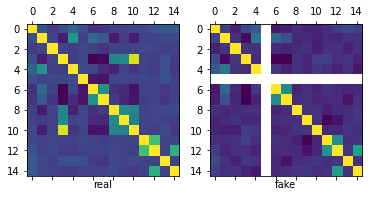

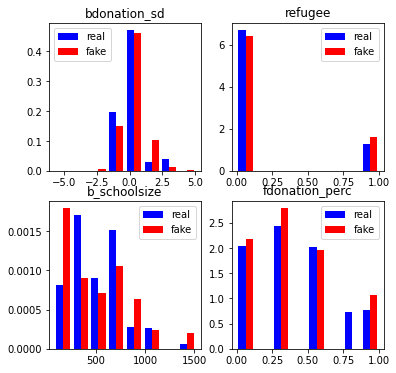

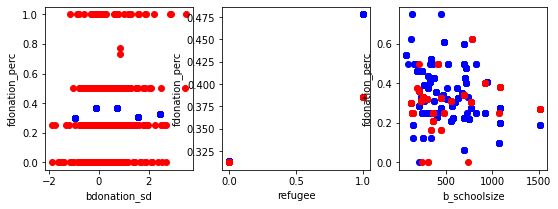

In [ ]:
print("att:", ((df_generated.fdonation_perc-df_generated.fdonation_perc_cf) * (2*df_generated.treatment - 1))[df_generated.treatment==1].mean())
wgan.compare_dfs(df, df_generated, 
                 scatterplot=dict(x=["bdonation_sd", "refugee", "b_schoolsize"], y=["fdonation_perc"], samples=400, smooth=0),
                 table_groupby=["treatment"],
                 histogram=dict(variables=["bdonation_sd", "refugee", "b_schoolsize","fdonation_perc"], nrow=2, ncol=2),
                 figsize=3)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/fraction_donated.csv',index_col=0)
df_generated = pd.read_csv('/content/drive/MyDrive/GANs-treatment/cohesion_generated_individual_0_0.csv',index_col=0)

att: 0.012152777777777778
-------------comparison of means-------------
treatment            0               1        
source            fake    real    fake    real
fdonation_perc    0.33    0.34    0.36    0.39
ageinm          104.83  105.14  104.66  105.37
male              0.53    0.51    0.53    0.50
bstrata          25.44   27.81   25.54   27.25
refugee           0.20    0.18    0.20    0.15
astudent          0.00    0.04    0.00    0.04
braven_sd         0.03   -0.02    0.05   -0.04
beyes_sd         -0.06    0.03   -0.03    0.02
b_schoolsize    527.26  521.38  526.71  534.64
f_csize          37.29   36.33   37.25   35.99
b_schoolid      141.26  157.51  141.41  152.19
a2                0.49    0.49    0.50    0.49
inter1            0.28    0.00    0.27    0.49
bdonation_sd      0.28   -0.05    0.23   -0.06
-------------comparison of stds-------------
treatment            0               1        
source            fake    real    fake    real
fdonation_perc    0.32    0.31    0.3

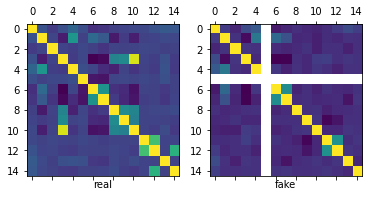

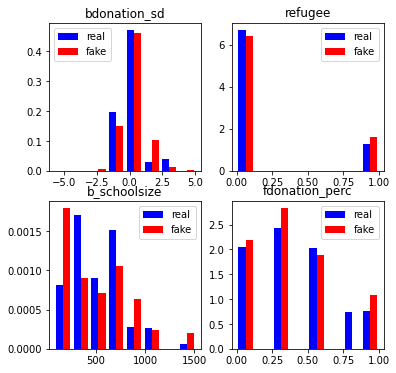

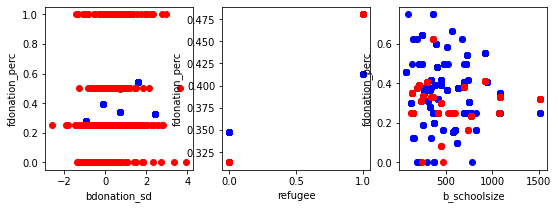

In [ ]:
print("att:", ((df_generated.fdonation_perc-df_generated.fdonation_perc_cf) * (2*df_generated.treatment - 1))[df_generated.treatment==1].mean())
wgan.compare_dfs(df, df_generated, 
                 scatterplot=dict(x=["bdonation_sd", "refugee", "b_schoolsize"], y=["fdonation_perc"], samples=400, smooth=0),
                 table_groupby=["treatment"],
                 histogram=dict(variables=["bdonation_sd", "refugee", "b_schoolsize","fdonation_perc"], nrow=2, ncol=2),
                 figsize=3)

### Configuration 3

In this configuration, we condition on treatment, school_id, and strata, but do not generate any class or school level covariates

In [ ]:
df2_balanced = df2.sample(2*len(df2), weights=(1-df2.treatment.mean())*df2.treatment+df2.treatment.mean()*(1-df2.treatment), replace=True) # balanced df for training

# X | t
continuous_vars_0 = ["ageinm", "braven_sd", "beyes_sd", "bdonation_sd"]
continuous_lower_bounds_0 = {"b_schoolsize":0,"f_csize":0}
categorical_vars_0 = ["a2", "inter1", "male", "refugee","astudent"]
context_vars_0 = ["treatment","b_schoolid","bstrata"]

# Y | X, t
continuous_vars_1 = []
continuous_lower_bounds_1 = {}
categorical_vars_1 = ["fdonation_perc"]
context_vars_1 = ["ageinm", "braven_sd", "beyes_sd", "b_schoolsize","f_csize","b_schoolid", "a2", "inter1", "male", "refugee","astudent","treatment","bstrata","bdonation_sd"]

# Initialize objects
data_wrappers = [wgan.DataWrapper(df2_balanced, continuous_vars_0, categorical_vars_0, 
                                  context_vars_0, continuous_lower_bounds_0),
                 wgan.DataWrapper(df2_balanced, continuous_vars_1, categorical_vars_1, 
                                  context_vars_1, continuous_lower_bounds_1)]
specs = [wgan.Specifications(dw, batch_size=4096, max_epochs=1000, critic_lr=1e-3, generator_lr=1e-3,
                             print_every=100, device = "cuda") for dw in data_wrappers]
generators = [wgan.Generator(spec) for spec in specs]
critics = [wgan.Critic(spec) for spec in specs]

settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 15, 'critic_lr': 0.001, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 0.001, 'generator_d_noise': 14, 'generator_optimizer': 'optimizer', 'max_epochs': 1000, 'batch_size': 4096, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 100, 'device': 'cuda'}
settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 15, 'critic_lr': 0.001, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 0.001, 'generator_d_noise': 5, 'generator_optimizer': 'optimizer', 'max_epochs': 1000, 'batch_size': 4096, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 100, 'device': 'cuda'}


In [ ]:
for i in range(0,10):
  x, context = data_wrappers[0].preprocess(df2_balanced)
  wgan.train(generators[0], critics[0], x, context, specs[0])
  # train Y | X, t
  x, context = data_wrappers[1].preprocess(df2_balanced)
  wgan.train(generators[1], critics[1], x, context, specs[1])
  for j in range(0,100):
    # simulate data with conditional WGANs
    df2_generated = data_wrappers[0].apply_generator(generators[0], df2)
    df2_generated = data_wrappers[1].apply_generator(generators[1], df2_generated)


    #add counterfactual outcomes
    df2_generated_cf = copy(df2_generated)
    df2_generated_cf["treatment"] = 1 - df2_generated_cf["treatment"] 
    df2_generated["fdonation_perc_cf"] = data_wrappers[1].apply_generator(generators[1], df2_generated_cf)['fdonation_perc']
    
    #randomize treatment and re-generate outcome
    df2_individual = copy(df2_generated)
    df2_individual['treatment'] = np.random.choice([1,0],len(df2_individual),p=[.5,.5])
    df2_individual = data_wrappers[1].apply_generator(generators[1], df2_individual)
    
    #save
    df2_generated.to_csv('/content/drive/MyDrive/GANs-full/cohesion_treatment_'+str(i)+'_'+str(j)+'.csv')
    df2_individual.to_csv('/content/drive/MyDrive/GANs-full/cohesion_generated_individual_'+str(i)+'_'+str(j)+'.csv')

epoch 0 | step 5 | WD_test 0.1 | WD_train 0.04 | sec passed 0 |
epoch 100 | step 405 | WD_test 1.29 | WD_train 1.36 | sec passed 12 |
epoch 200 | step 805 | WD_test 1.0 | WD_train 1.08 | sec passed 12 |
epoch 300 | step 1205 | WD_test 0.9 | WD_train 0.87 | sec passed 12 |
epoch 400 | step 1605 | WD_test 0.56 | WD_train 0.73 | sec passed 12 |
epoch 500 | step 2005 | WD_test 0.72 | WD_train 0.62 | sec passed 12 |
epoch 600 | step 2405 | WD_test 0.36 | WD_train 0.42 | sec passed 12 |
epoch 700 | step 2805 | WD_test 0.73 | WD_train 0.59 | sec passed 12 |
epoch 800 | step 3205 | WD_test 0.35 | WD_train 0.58 | sec passed 12 |
epoch 900 | step 3605 | WD_test 0.43 | WD_train 0.49 | sec passed 12 |
epoch 0 | step 5 | WD_test 0.02 | WD_train 0.0 | sec passed 0 |
epoch 100 | step 405 | WD_test 0.73 | WD_train 0.73 | sec passed 12 |
epoch 200 | step 805 | WD_test 0.24 | WD_train 0.28 | sec passed 12 |
epoch 300 | step 1205 | WD_test 0.3 | WD_train 0.27 | sec passed 12 |
epoch 400 | step 1605 | WD_

We can generate Configuration 3's correlation and means comparisons for the school-randomized and individual randomized data below:

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/fraction_donated.csv',index_col=0)
df_generated = pd.read_csv('/content/drive/MyDrive/GANs-full/cohesion_treatment_0_0.csv',index_col=0)

att: 0.044366967459666395
-------------comparison of means-------------
treatment            0               1        
source            fake    real    fake    real
fdonation_perc    0.31    0.34    0.35    0.39
ageinm          105.45  105.14  105.42  105.37
male              0.50    0.51    0.49    0.50
bstrata          27.81   27.81   27.25   27.25
refugee           0.16    0.18    0.11    0.15
astudent          0.00    0.04    0.00    0.04
braven_sd         0.03   -0.02   -0.02   -0.04
beyes_sd         -0.19    0.03   -0.14    0.02
b_schoolsize    521.38  521.38  534.64  534.64
f_csize          36.33   36.33   35.99   35.99
b_schoolid      157.51  157.51  152.19  152.19
a2                0.49    0.49    0.49    0.49
inter1            0.02    0.00    0.49    0.49
bdonation_sd     -0.09   -0.05   -0.04   -0.06
-------------comparison of stds-------------
treatment            0               1        
source            fake    real    fake    real
fdonation_perc    0.24    0.31    0.2

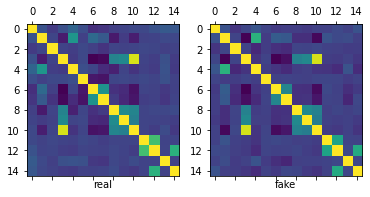

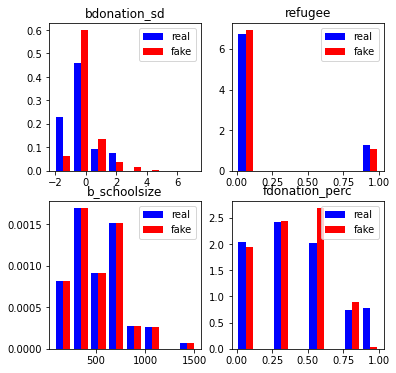

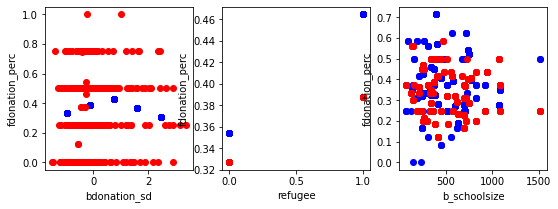

In [ ]:
print("att:", ((df_generated.fdonation_perc-df_generated.fdonation_perc_cf) * (2*df_generated.treatment - 1))[df_generated.treatment==1].mean())
wgan.compare_dfs(df, df_generated, 
                 scatterplot=dict(x=["bdonation_sd", "refugee", "b_schoolsize"], y=["fdonation_perc"], samples=400, smooth=0),
                 table_groupby=["treatment"],
                 histogram=dict(variables=["bdonation_sd", "refugee", "b_schoolsize","fdonation_perc"], nrow=2, ncol=2),
                 figsize=3)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/fraction_donated.csv',index_col=0)
df_generated = pd.read_csv('/content/drive/MyDrive/GANs-full/cohesion_generated_individual_0_0.csv',index_col=0)

att: 0.02683745044220799
-------------comparison of means-------------
treatment            0               1        
source            fake    real    fake    real
fdonation_perc    0.31    0.34    0.35    0.39
ageinm          105.52  105.14  105.36  105.37
male              0.50    0.51    0.50    0.50
bstrata          27.57   27.81   27.43   27.25
refugee           0.13    0.18    0.13    0.15
astudent          0.00    0.04    0.00    0.04
braven_sd         0.01   -0.02    0.00   -0.04
beyes_sd         -0.15    0.03   -0.17    0.02
b_schoolsize    526.61  521.38  530.91  534.64
f_csize          36.18   36.33   36.10   35.99
b_schoolid      155.04  157.51  154.05  152.19
a2                0.50    0.49    0.49    0.49
inter1            0.28    0.00    0.28    0.49
bdonation_sd     -0.07   -0.05   -0.06   -0.06
-------------comparison of stds-------------
treatment            0               1        
source            fake    real    fake    real
fdonation_perc    0.25    0.31    0.24

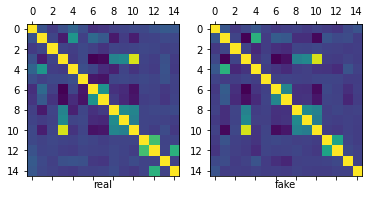

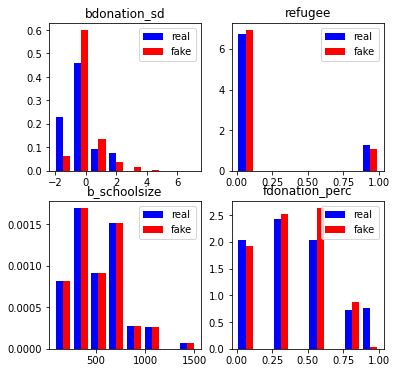

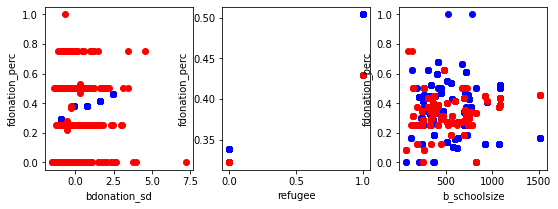

In [ ]:
print("att:", ((df_generated.fdonation_perc-df_generated.fdonation_perc_cf) * (2*df_generated.treatment - 1))[df_generated.treatment==1].mean())
wgan.compare_dfs(df, df_generated, 
                 scatterplot=dict(x=["bdonation_sd", "refugee", "b_schoolsize"], y=["fdonation_perc"], samples=400, smooth=0),
                 table_groupby=["treatment"],
                 histogram=dict(variables=["bdonation_sd", "refugee", "b_schoolsize","fdonation_perc"], nrow=2, ncol=2),
                 figsize=3)

### Configuration 4

In this configuration, we condition on treatment, school_id, and strata, and generate school and class size as categorical variables

In [ ]:
df2_balanced = df2.sample(2*len(df2), weights=(1-df2.treatment.mean())*df2.treatment+df2.treatment.mean()*(1-df2.treatment), replace=True) # balanced df for training

# X | t
continuous_vars_0 = ["ageinm", "braven_sd", "beyes_sd", "bdonation_sd"]
continuous_lower_bounds_0 = {"b_schoolsize":0,"f_csize":0}
categorical_vars_0 = ["a2", "inter1", "male", "refugee","astudent","b_schoolsize","f_csize"]
context_vars_0 = ["treatment","b_schoolid","bstrata"]

# Y | X, t
continuous_vars_1 = []
continuous_lower_bounds_1 = {}
categorical_vars_1 = ["fdonation_perc"]
context_vars_1 = ["ageinm", "braven_sd", "beyes_sd", "b_schoolsize","f_csize","b_schoolid", "a2", "inter1", "male", "refugee","astudent","treatment","bstrata","bdonation_sd"]

# Initialize objects
data_wrappers = [wgan.DataWrapper(df2_balanced, continuous_vars_0, categorical_vars_0, 
                                  context_vars_0, continuous_lower_bounds_0),
                 wgan.DataWrapper(df2_balanced, continuous_vars_1, categorical_vars_1, 
                                  context_vars_1, continuous_lower_bounds_1)]
specs = [wgan.Specifications(dw, batch_size=4096, max_epochs=1000, critic_lr=1e-3, generator_lr=1e-3,
                             print_every=100, device = "cuda") for dw in data_wrappers]
generators = [wgan.Generator(spec) for spec in specs]
critics = [wgan.Critic(spec) for spec in specs]

settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 15, 'critic_lr': 0.001, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 0.001, 'generator_d_noise': 120, 'generator_optimizer': 'optimizer', 'max_epochs': 1000, 'batch_size': 4096, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 100, 'device': 'cuda'}
settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 15, 'critic_lr': 0.001, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 0.001, 'generator_d_noise': 5, 'generator_optimizer': 'optimizer', 'max_epochs': 1000, 'batch_size': 4096, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 100, 'device': 'cuda'}


In [ ]:
for i in range(0,10):
  x, context = data_wrappers[0].preprocess(df2_balanced)
  wgan.train(generators[0], critics[0], x, context, specs[0])
  # train Y | X, t
  x, context = data_wrappers[1].preprocess(df2_balanced)
  wgan.train(generators[1], critics[1], x, context, specs[1])
  for j in range(0,100):
    # simulate data with conditional WGANs
    df2_generated = data_wrappers[0].apply_generator(generators[0], df2)
    df2_generated = data_wrappers[1].apply_generator(generators[1], df2_generated)


    #add counterfactual outcomes
    df2_generated_cf = copy(df2_generated)
    df2_generated_cf["treatment"] = 1 - df2_generated_cf["treatment"] 
    df2_generated["fdonation_perc_cf"] = data_wrappers[1].apply_generator(generators[1], df2_generated_cf)['fdonation_perc']
    
    #randomize treatment and re-generate outcome
    df2_individual = copy(df2_generated)
    df2_individual['treatment'] = np.random.choice([1,0],len(df2_individual),p=[.5,.5])
    df2_individual = data_wrappers[1].apply_generator(generators[1], df2_individual)
    
    #save
    df2_generated.to_csv('/content/drive/MyDrive/GANs-original/cohesion_treatment_'+str(i)+'_'+str(j)+'.csv')
    df2_individual.to_csv('/content/drive/MyDrive/GANs-original/cohesion_generated_individual_'+str(i)+'_'+str(j)+'.csv')


epoch 0 | step 5 | WD_test 0.05 | WD_train 0.02 | sec passed 7 |
epoch 100 | step 405 | WD_test 1.63 | WD_train 1.59 | sec passed 15 |
epoch 200 | step 805 | WD_test 1.55 | WD_train 1.42 | sec passed 15 |
epoch 300 | step 1205 | WD_test 1.44 | WD_train 1.31 | sec passed 16 |
epoch 400 | step 1605 | WD_test 1.4 | WD_train 1.32 | sec passed 15 |
epoch 500 | step 2005 | WD_test 1.26 | WD_train 1.36 | sec passed 15 |
epoch 600 | step 2405 | WD_test 1.35 | WD_train 1.32 | sec passed 15 |
epoch 700 | step 2805 | WD_test 1.22 | WD_train 1.32 | sec passed 15 |
epoch 800 | step 3205 | WD_test 1.32 | WD_train 1.31 | sec passed 15 |
epoch 900 | step 3605 | WD_test 1.23 | WD_train 1.19 | sec passed 15 |
epoch 0 | step 5 | WD_test 0.01 | WD_train 0.0 | sec passed 0 |
epoch 100 | step 405 | WD_test 0.72 | WD_train 0.69 | sec passed 13 |
epoch 200 | step 805 | WD_test 0.35 | WD_train 0.37 | sec passed 13 |
epoch 300 | step 1205 | WD_test 0.27 | WD_train 0.28 | sec passed 13 |
epoch 400 | step 1605 | 

We can then compare means and correlations with the real data for the school randomized and individual randomized versions. Note we use one of our 1000 datasets. 

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/fraction_donated.csv',index_col=0)
df_generated = pd.read_csv('/content/drive/MyDrive/GANs-original/cohesion_treatment_0_0.csv',index_col=0)

att: 0.04621274268526114
-------------comparison of means-------------
treatment            0               1        
source            fake    real    fake    real
fdonation_perc    0.24    0.34    0.28    0.39
ageinm          104.39  105.14  104.06  105.37
male              0.49    0.51    0.48    0.50
bstrata          27.81   27.81   27.25   27.25
refugee           0.22    0.18    0.17    0.15
astudent          0.00    0.04    0.00    0.04
braven_sd         0.82   -0.02    0.66   -0.04
beyes_sd          0.08    0.03    0.00    0.02
b_schoolsize    534.59  521.38  509.73  534.64
f_csize          32.17   36.33   32.23   35.99
b_schoolid      157.51  157.51  152.19  152.19
a2                0.45    0.49    0.50    0.49
inter1            0.04    0.00    0.50    0.49
bdonation_sd      0.03   -0.05    0.05   -0.06
-------------comparison of stds-------------
treatment            0               1        
source            fake    real    fake    real
fdonation_perc    0.20    0.31    0.20

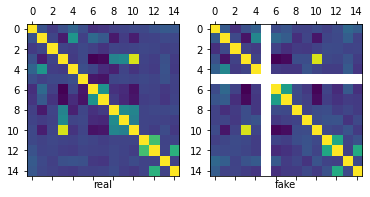

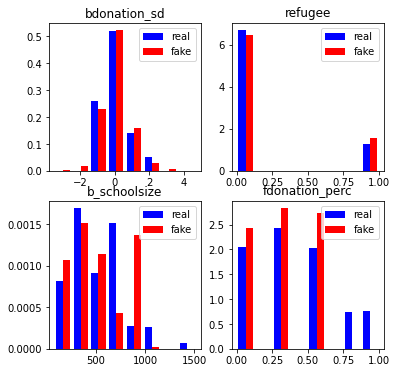

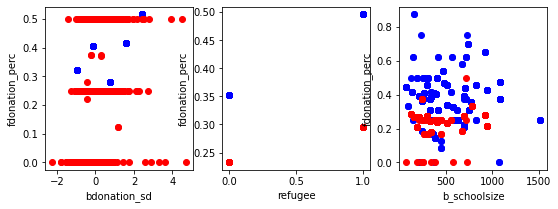

In [ ]:
print("att:", ((df_generated.fdonation_perc-df_generated.fdonation_perc_cf) * (2*df_generated.treatment - 1))[df_generated.treatment==1].mean())
wgan.compare_dfs(df, df_generated, 
                 scatterplot=dict(x=["bdonation_sd", "refugee", "b_schoolsize"], y=["fdonation_perc"], samples=400, smooth=0),
                 table_groupby=["treatment"],
                 histogram=dict(variables=["bdonation_sd", "refugee", "b_schoolsize","fdonation_perc"], nrow=2, ncol=2),
                 figsize=3)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/fraction_donated.csv',index_col=0)
df_generated = pd.read_csv('/content/drive/MyDrive/GANs-original/cohesion_generated_individual_0_0.csv',index_col=0)

att: 0.02827648114901257
-------------comparison of means-------------
treatment            0               1        
source            fake    real    fake    real
fdonation_perc    0.23    0.34    0.28    0.39
ageinm          104.27  105.14  104.15  105.37
male              0.48    0.51    0.49    0.50
bstrata          27.38   27.81   27.61   27.25
refugee           0.20    0.18    0.20    0.15
astudent          0.00    0.04    0.00    0.04
braven_sd         0.72   -0.02    0.74   -0.04
beyes_sd          0.03    0.03    0.05    0.02
b_schoolsize    519.60  521.38  521.90  534.64
f_csize          32.22   36.33   32.19   35.99
b_schoolid      153.25  157.51  155.81  152.19
a2                0.47    0.49    0.49    0.49
inter1            0.30    0.00    0.30    0.49
bdonation_sd      0.04   -0.05    0.04   -0.06
-------------comparison of stds-------------
treatment            0               1        
source            fake    real    fake    real
fdonation_perc    0.20    0.31    0.20

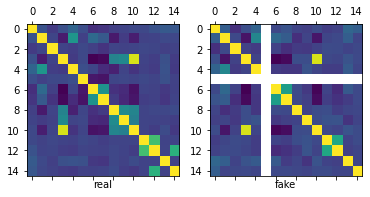

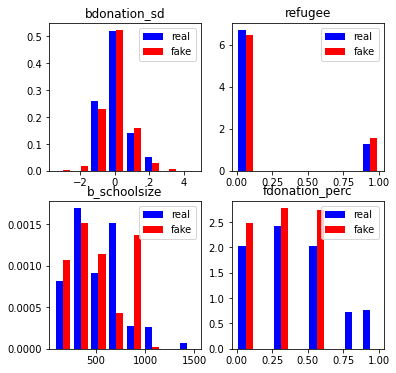

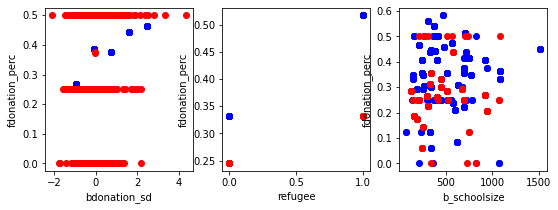

In [ ]:
print("att:", ((df_generated.fdonation_perc-df_generated.fdonation_perc_cf) * (2*df_generated.treatment - 1))[df_generated.treatment==1].mean())
wgan.compare_dfs(df, df_generated, 
                 scatterplot=dict(x=["bdonation_sd", "refugee", "b_schoolsize"], y=["fdonation_perc"], samples=400, smooth=0),
                 table_groupby=["treatment"],
                 histogram=dict(variables=["bdonation_sd", "refugee", "b_schoolsize","fdonation_perc"], nrow=2, ncol=2),
                 figsize=3)

### Configuration 5

In this configuration, we condition on treatment, school_id, and strata, and generate school and class size as continuous variables

In [ ]:
df2_balanced = df2.sample(2*len(df2), weights=(1-df2.treatment.mean())*df2.treatment+df2.treatment.mean()*(1-df2.treatment), replace=True) # balanced df for training

# X | t
continuous_vars_0 = ["ageinm", "braven_sd", "beyes_sd", "bdonation_sd","b_schoolsize","f_csize"]
continuous_lower_bounds_0 = {"b_schoolsize":0,"f_csize":0}
categorical_vars_0 = ["a2", "inter1", "male", "refugee","astudent"]
context_vars_0 = ["treatment","b_schoolid","bstrata"]

# Y | X, t
continuous_vars_1 = []
continuous_lower_bounds_1 = {}
categorical_vars_1 = ["fdonation_perc"]
context_vars_1 = ["ageinm", "braven_sd", "beyes_sd", "b_schoolsize","f_csize","b_schoolid", "a2", "inter1", "male", "refugee","astudent","treatment","bstrata","bdonation_sd"]

# Initialize objects
data_wrappers = [wgan.DataWrapper(df2_balanced, continuous_vars_0, categorical_vars_0, 
                                  context_vars_0, continuous_lower_bounds_0),
                 wgan.DataWrapper(df2_balanced, continuous_vars_1, categorical_vars_1, 
                                  context_vars_1, continuous_lower_bounds_1)]
specs = [wgan.Specifications(dw, batch_size=4096, max_epochs=1000, critic_lr=1e-3, generator_lr=1e-3,
                             print_every=100, device = "cuda") for dw in data_wrappers]
generators = [wgan.Generator(spec) for spec in specs]
critics = [wgan.Critic(spec) for spec in specs]

settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 15, 'critic_lr': 0.001, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 0.001, 'generator_d_noise': 16, 'generator_optimizer': 'optimizer', 'max_epochs': 1000, 'batch_size': 4096, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 100, 'device': 'cuda'}
settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 15, 'critic_lr': 0.001, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 0.001, 'generator_d_noise': 5, 'generator_optimizer': 'optimizer', 'max_epochs': 1000, 'batch_size': 4096, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 100, 'device': 'cuda'}


In [ ]:
for i in range(0,10):
  x, context = data_wrappers[0].preprocess(df2_balanced)
  wgan.train(generators[0], critics[0], x, context, specs[0])
  # train Y | X, t
  x, context = data_wrappers[1].preprocess(df2_balanced)
  wgan.train(generators[1], critics[1], x, context, specs[1])
  for j in range(0,100):
    # simulate data with conditional WGANs
    df2_generated = data_wrappers[0].apply_generator(generators[0], df2)
    df2_generated = data_wrappers[1].apply_generator(generators[1], df2_generated)


    #add counterfactual outcomes
    df2_generated_cf = copy(df2_generated)
    df2_generated_cf["treatment"] = 1 - df2_generated_cf["treatment"] 
    df2_generated["fdonation_perc_cf"] = data_wrappers[1].apply_generator(generators[1], df2_generated_cf)['fdonation_perc']
    
    #randomize treatment and re-generate outcome
    df2_individual = copy(df2_generated)
    df2_individual['treatment'] = np.random.choice([1,0],len(df2_individual),p=[.5,.5])
    df2_individual = data_wrappers[1].apply_generator(generators[1], df2_individual)
    
    #save
    df2_generated.to_csv('/content/drive/MyDrive/GANs-continuous/cohesion_treatment_'+str(i)+'_'+str(j)+'.csv')
    df2_individual.to_csv('/content/drive/MyDrive/GANs-continuous/cohesion_generated_individual_'+str(i)+'_'+str(j)+'.csv')

epoch 0 | step 5 | WD_test 0.13 | WD_train 0.05 | sec passed 0 |
epoch 100 | step 405 | WD_test 1.61 | WD_train 1.63 | sec passed 14 |
epoch 200 | step 805 | WD_test 1.01 | WD_train 1.09 | sec passed 13 |
epoch 300 | step 1205 | WD_test 0.97 | WD_train 1.01 | sec passed 14 |
epoch 400 | step 1605 | WD_test 0.87 | WD_train 0.95 | sec passed 13 |
epoch 500 | step 2005 | WD_test 0.98 | WD_train 0.92 | sec passed 14 |
epoch 600 | step 2405 | WD_test 0.72 | WD_train 0.84 | sec passed 14 |
epoch 700 | step 2805 | WD_test 0.89 | WD_train 0.92 | sec passed 14 |
epoch 800 | step 3205 | WD_test 0.9 | WD_train 0.91 | sec passed 14 |
epoch 900 | step 3605 | WD_test 1.28 | WD_train 0.93 | sec passed 14 |
epoch 0 | step 5 | WD_test 0.02 | WD_train 0.01 | sec passed 0 |
epoch 100 | step 405 | WD_test 0.88 | WD_train 0.76 | sec passed 14 |
epoch 200 | step 805 | WD_test 0.37 | WD_train 0.39 | sec passed 14 |
epoch 300 | step 1205 | WD_test 0.3 | WD_train 0.27 | sec passed 13 |
epoch 400 | step 1605 | 

We can then compare means and correlations with the real data for the school randomized and individual randomized versions. Note we use one of our 1000 datasets. 

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/fraction_donated.csv',index_col=0)
df_generated = pd.read_csv('/content/drive/MyDrive/GANs-continuous/cohesion_treatment_0_0.csv',index_col=0)

att: 0.031173092698933553
-------------comparison of means-------------
treatment            0               1        
source            fake    real    fake    real
fdonation_perc    0.23    0.34    0.28    0.39
ageinm          104.93  105.14  105.64  105.37
male              0.53    0.51    0.52    0.50
bstrata          27.81   27.81   27.25   27.25
refugee           0.17    0.18    0.15    0.15
astudent          0.00    0.04    0.00    0.04
braven_sd         0.13   -0.02    0.09   -0.04
beyes_sd         -0.01    0.03    0.03    0.02
b_schoolsize    503.23  521.38  509.85  534.64
f_csize          34.68   36.33   34.49   35.99
b_schoolid      157.51  157.51  152.19  152.19
a2                0.48    0.49    0.49    0.49
inter1            0.01    0.00    0.46    0.49
bdonation_sd      0.03   -0.05    0.03   -0.06
-------------comparison of stds-------------
treatment            0               1        
source            fake    real    fake    real
fdonation_perc    0.20    0.31    0.1

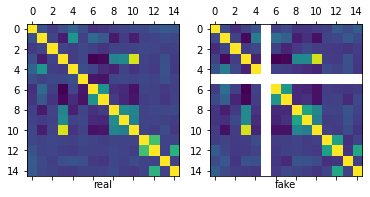

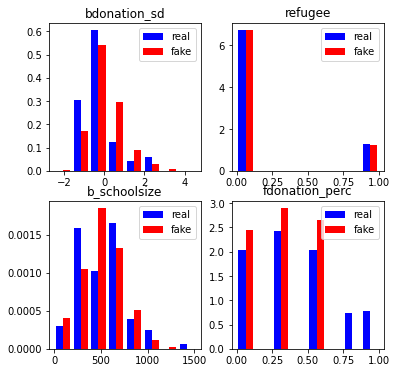

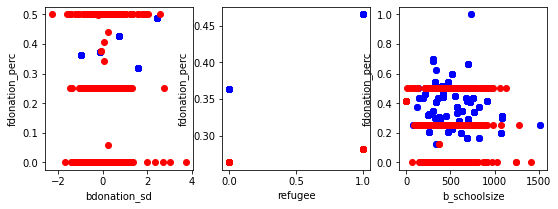

In [ ]:
print("att:", ((df_generated.fdonation_perc-df_generated.fdonation_perc_cf) * (2*df_generated.treatment - 1))[df_generated.treatment==1].mean())
wgan.compare_dfs(df, df_generated, 
                 scatterplot=dict(x=["bdonation_sd", "refugee", "b_schoolsize"], y=["fdonation_perc"], samples=400, smooth=0),
                 table_groupby=["treatment"],
                 histogram=dict(variables=["bdonation_sd", "refugee", "b_schoolsize","fdonation_perc"], nrow=2, ncol=2),
                 figsize=3)

In [ ]:
df_generated = pd.read_csv('/content/drive/MyDrive/GANs-continuous/cohesion_generated_individual_0_0.csv',index_col=0)

att: 0.022573189522342066
-------------comparison of means-------------
treatment            0               1        
source            fake    real    fake    real
fdonation_perc    0.24    0.34    0.28    0.39
ageinm          105.29  105.14  105.36  105.37
male              0.53    0.51    0.53    0.50
bstrata          27.66   27.81   27.33   27.25
refugee           0.15    0.18    0.16    0.15
astudent          0.00    0.04    0.00    0.04
braven_sd         0.12   -0.02    0.10   -0.04
beyes_sd          0.02    0.03   -0.00    0.02
b_schoolsize    508.72  521.38  505.05  534.64
f_csize          34.70   36.33   34.44   35.99
b_schoolid      156.08  157.51  152.97  152.19
a2                0.49    0.49    0.49    0.49
inter1            0.27    0.00    0.26    0.49
bdonation_sd      0.03   -0.05    0.03   -0.06
-------------comparison of stds-------------
treatment            0               1        
source            fake    real    fake    real
fdonation_perc    0.20    0.31    0.1

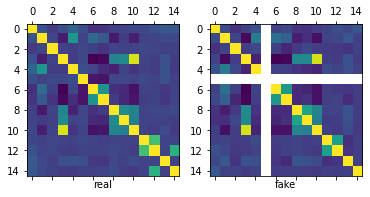

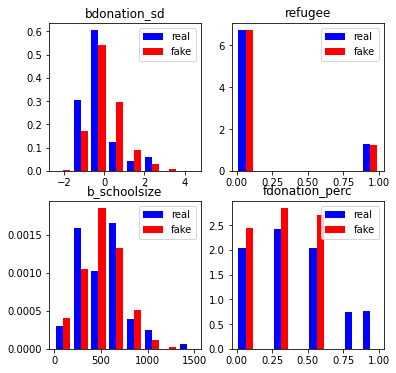

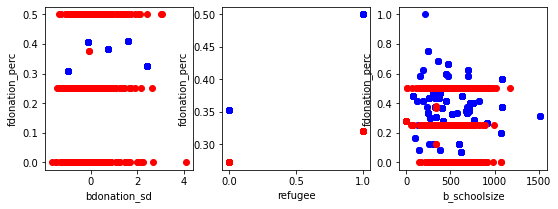

In [ ]:
print("att:", ((df_generated.fdonation_perc-df_generated.fdonation_perc_cf) * (2*df_generated.treatment - 1))[df_generated.treatment==1].mean())
wgan.compare_dfs(df, df_generated, 
                 scatterplot=dict(x=["bdonation_sd", "refugee", "b_schoolsize"], y=["fdonation_perc"], samples=400, smooth=0),
                 table_groupby=["treatment"],
                 histogram=dict(variables=["bdonation_sd", "refugee", "b_schoolsize","fdonation_perc"], nrow=2, ncol=2),
                 figsize=3)